# Determing the Best Loss Optimizer
Comparing SGD vs Adam Optimizer vs. Nadam Optimizer

### Model
- model = GRU
- batch_size = 32
- epochs = 100
- loss = mse


### Data
- time frame: 6 months | 6 months
- features: all of them (110)
- target: EDSS_6...EDSS_222
- imputation 
    - target: interpolation (trailing ends for extrapolation)
    - features: zero-imputation
- time steps: exhaustive (37)

In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import sklearn as sk
from matplotlib import pyplot as plt

import keras.layers as L
import keras.models as M

/Users/matiasberretta/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def select_columns(col_list, n_months):
    
    """takes in a list of column names and number of visits starting at 0
    returns column list time-stepped and dovetailed""" 
    
    return dovetail_names(*[time_step_names(i, n_months) for i in col_list])
        
def time_step_names(name, n_months):

    return [(name + '_%d' % (j+1)) for j in range(-1,n_months*6, 6)]

def dovetail_names(*kwargs):
    zipped = zip(*kwargs)
    l = []
    for i in zipped:
        for j in i:
            l.append(j)
    return l

def stretch_input(Xtr, n_inputs, time_steps, pot):

    """Xtr_fill is empty 3D numpy array where we extend length of patient observation times t
    pot stands for Patient Observation Time. We only need to do this for our X input"""
    
    Xtr_fill = np.zeros(shape=[Xtr.shape[0],time_steps,n_inputs*pot] , dtype = object) 

    for subject in range(Xtr.shape[0]):
    
        for i in range(time_steps):

            temp = np.concatenate([Xtr[subject][i],Xtr[subject][i+1]]) # changed for pot = 3
            Xtr_fill[subject][i] = temp
            
    return Xtr_fill

def stack_times(data, name, n):
    
    
    """takes in dataframe, column name and n of time steps
    and puts it in long format"""
    
    all_names = select_columns(name, n-1)
    
    l = []
    
    for col in all_names:
        l.append(data[col].copy())
    
    stacked = l[0]
    rest = l[1:]
    
    # stack Series and get dummy variables 
    stacked.append(rest)
    
    return stacked

def stack_dummy(data, name, n):
    
    
    """takes in dataframe and column name
    return that same feature split into dummy columns
    across n time steps (adjacent)"""
    
    all_names = select_columns(name, n-1)
    
    l = []
    
    for col in all_names:
        l.append(data[col].copy())
    
    f = l[0]
    rest = l[1:]
    
    # stack Series and get dummy variables 
    pre_dummy = pd.get_dummies(f.append(rest))
    
    after_dummy = time_dummy(pre_dummy, n)
    
    dummy_value_names = generate_col_names(after_dummy, name)
    time_stepped_dummy_names = time_step_dummy_value_names(dummy_value_names, n)
    
    for t in range(len(after_dummy)):
        
        after_dummy[t].columns = list(time_stepped_dummy_names[t])
        
    #untimed_names_to_order = column_names_per_time_step(col_names_together, "what are you", name[0])
    #names_to_order = select_columns(untimed_names_to_order, n-1)

    return pd.concat(after_dummy, axis = 1, sort = False), dummy_value_names


def time_dummy(dummy_df, n):
    
    """Separates long data frame into time steps 
    (508 subjects (rows) per time step)"""
    
    l = []
    for i in range(n):
        l.append(dummy_df.iloc[i*508:(i+1)*508,:].copy())
    
    return l

def generate_col_names(after_dummy, name):
    
    """Generates column names for result of pd.get_dummies on a feature
    i.e. if A has values x and y, it will generate A_x, A_y"""
    
    return [(str(name[0]) + "_" + str(list(after_dummy[0].columns)[i])) for i in range(len(list(after_dummy[0].columns)))]

def time_step_dummy_value_names(names, n_months):
    
    long_list = [(name + '_%d' % (j+1)) for j in range(-1,n_months*6, 6) for name in names]
    return np.array(long_list).reshape(-1, len(names))

def add_columns(add_to, name, names_per_t, n):
    
    n = n + 1
    to_add, bare_names = stack_dummy(df, name, n)
    to_remove = select_columns(name, n-1)
    
    """add new dummied features to dataframes (copy)
    and remove undummied version of features
    name is a list
    
    encompasses stack_dummy"""
    
    newdf = add_to.copy()
    column_names = list(to_add.columns)
    
    for i in range(len(column_names)):
        newdf[column_names[i]] = to_add.iloc[:,i]
    newdf.drop(to_remove,axis = 1, inplace = True)
    
    #print(bare_names, name[0])
    
    names_per_t_updated = column_names_per_time_step(names_per_t, bare_names, name[0])
    namesOrder= select_columns(names_per_t_updated, n-1)
    return newdf[namesOrder].copy(), names_per_t_updated

#    return names_per_t_updated
#     print(name[0])
    
    
    return newdf[namesOrder].copy(), names_per_t_updated


def column_names_per_time_step(original_list, add, remove):
    """makes sure EDSS stays at the end
    remove pre """
    
    new_list = original_list.copy()
    
    
    new_list.remove(remove)
    new_list.extend(add)
    
    # makes sure EDSS is always last
    
    new_list.remove('EDSS')
    new_list.append('EDSS')
    
    return new_list

def manual_dummy(df, names, name_list, n):
    
    dfUpdated =df.copy()
    names = [[name] for name in names] # turn to list foramt so that it works
    
    for name in names:
        
        dfUpdated, name_list = add_columns(dfUpdated, name , name_list, n)
   
    return dfUpdated # should I return name_list as well?


# IMPORT DATA & DEFINE N OF TIME STEPS

In [3]:
X = pd.read_csv("../data/X_6_months|6_months_exhaustive.csv", index_col = 0)
y = pd.read_csv("../data/y_6_months|6_months_exhaustive.csv", index_col = 0)

predictive_features = pd.read_csv("../data/predictive_features_list.csv", index_col = 0, header = None)
predictive_features_list = predictive_features[1].values.tolist()

n_time_steps = len(y.columns)
n_inputs_pure = X.columns.tolist().index("EDSS_0")+1

pot = 1
print("The RNN window will slide", n_time_steps, "times")
print("The input length of the training data will be", pot, "time slices, separated by 6 month intervals")
print("There will be", n_inputs_pure, "per time step")

The RNN window will slide 37 times
The input length of the training data will be 1 time slices, separated by 6 month intervals
There will be 110 per time step


# Split into train and test

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

X_train_reshaped = X_train.values.reshape(-1, n_time_steps, n_inputs_pure) 
y_train_reshaped = y_train.values.reshape(-1, n_time_steps, 1)
print("X reshaped is " + str(X_train_reshaped.shape))
print("y reshaped is " + str(y_train_reshaped.shape))

X_test_reshaped = X_test.values.reshape(-1, n_time_steps, n_inputs_pure)
y_test_reshaped = y_test.values.reshape(-1, n_time_steps, 1)
print("X reshaped is " + str(X_test_reshaped.shape))
print("y reshaped is " + str(y_test_reshaped.shape))

y_train = y_train_reshaped.astype(float)
y_test = y_test_reshaped.astype(float)
X_train = X_train_reshaped.astype(float)
X_test = X_test_reshaped.astype(float)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

X reshaped is (355, 37, 110)
y reshaped is (355, 37, 1)
X reshaped is (153, 37, 110)
y reshaped is (153, 37, 1)
(355, 37, 110) (355, 37, 1) (153, 37, 110) (153, 37, 1)


# Set values for the neuron

In [5]:
n_inputs = n_inputs_pure * pot

n_units = 15

n_output = 1

learning_rate = 0.01

print(n_inputs, "inputs per time step (",n_time_steps,") comprising", pot, "time slice,", n_inputs_pure, "features each")

110 inputs per time step ( 37 ) comprising 1 time slice, 110 features each


### SGD Optimizer 

In [16]:
model_sgd = M.Sequential()

# Each input data point has 37 timesteps, each with 110 features.
# So the input shape (excluding batch_size) is (37, 110)

model_sgd.add(L.GRU(64, input_shape=(n_time_steps, n_inputs), return_sequences=True))
model_sgd.add(L.Dense(n_output, activation='linear'))
model_sgd.compile(optimizer = 'sgd', loss = 'mean_squared_error')

history_sgd = model_sgd.fit(X_train, y_train, batch_size = 32, 
                              epochs=100, validation_data=(X_test, y_test), 
                              shuffle=True)

Train on 355 samples, validate on 153 samples
Epoch 1/100
355/355 [==============================] - 3s 7ms/step - loss: 4.1419 - val_loss: 1.9385
Epoch 2/100
355/355 [==============================] - 1s 3ms/step - loss: 1.1230 - val_loss: 3.8270
Epoch 3/100
355/355 [==============================] - 1s 3ms/step - loss: 1.1464 - val_loss: 0.6962
Epoch 4/100
355/355 [==============================] - 1s 3ms/step - loss: 0.5379 - val_loss: 1.1945
Epoch 5/100
355/355 [==============================] - 1s 3ms/step - loss: 0.6528 - val_loss: 1.4388
Epoch 6/100
355/355 [==============================] - 1s 3ms/step - loss: 0.6196 - val_loss: 0.6277
Epoch 7/100
355/355 [==============================] - 1s 3ms/step - loss: 0.4110 - val_loss: 0.5995
Epoch 8/100
355/355 [==============================] - 1s 3ms/step - loss: 0.4511 - val_loss: 0.5277
Epoch 9/100
355/355 [==============================] - 1s 3ms/step - loss: 0.4408 - val_loss: 0.4987
Epoch 10/100
355/355 [=======================

Epoch 81/100
355/355 [==============================] - 1s 3ms/step - loss: 0.2905 - val_loss: 0.3651
Epoch 82/100
355/355 [==============================] - 1s 3ms/step - loss: 0.2856 - val_loss: 0.3765
Epoch 83/100
355/355 [==============================] - 1s 3ms/step - loss: 0.2882 - val_loss: 0.3695
Epoch 84/100
355/355 [==============================] - 1s 3ms/step - loss: 0.2895 - val_loss: 0.3612
Epoch 85/100
355/355 [==============================] - 1s 3ms/step - loss: 0.2858 - val_loss: 0.3681
Epoch 86/100
355/355 [==============================] - 1s 3ms/step - loss: 0.2818 - val_loss: 0.3589
Epoch 87/100
355/355 [==============================] - 1s 3ms/step - loss: 0.2802 - val_loss: 0.4304
Epoch 88/100
355/355 [==============================] - 1s 3ms/step - loss: 0.2803 - val_loss: 0.3610
Epoch 89/100
355/355 [==============================] - 1s 3ms/step - loss: 0.2746 - val_loss: 0.3491
Epoch 90/100
355/355 [==============================] - 1s 3ms/step - loss: 0.2737

In [ ]:
mse_test_sgd = history_sgd.__dict__['history']['val_loss']
mse_train_sgd = history_sgd.__dict__['history']['loss']
sgd_params = history_sgd.__dict__['params']

### Adam Optimizer

In [ ]:
model_adam = M.Sequential()

# Each input data point has 37 timesteps, each with 110 features.
# So the input shape (excluding batch_size) is (37, 110)

model_adam.add(L.GRU(64, input_shape=(n_time_steps, n_inputs), return_sequences=True))
model_adam.add(L.Dense(n_output, activation='linear'))
model_adam.compile(optimizer = 'adam', loss = 'mean_squared_error')

history_adam = model_adam.fit(X_train, y_train, batch_size = 32, 
                              epochs=100, validation_data=(X_test, y_test), 
                              shuffle=True)

Train on 355 samples, validate on 153 samples
Epoch 1/100
355/355 [==============================] - 2s 7ms/step - loss: 5.0310 - val_loss: 5.0641
Epoch 2/100
355/355 [==============================] - 1s 3ms/step - loss: 2.9913 - val_loss: 3.6325
Epoch 3/100
355/355 [==============================] - 1s 3ms/step - loss: 1.9190 - val_loss: 2.2215
Epoch 4/100
355/355 [==============================] - 1s 3ms/step - loss: 1.0971 - val_loss: 1.4284
Epoch 5/100
355/355 [==============================] - 1s 3ms/step - loss: 0.7084 - val_loss: 1.0778
Epoch 6/100
355/355 [==============================] - 1s 3ms/step - loss: 0.5726 - val_loss: 0.9403
Epoch 7/100
355/355 [==============================] - 1s 3ms/step - loss: 0.4935 - val_loss: 0.8576
Epoch 8/100
355/355 [==============================] - 1s 3ms/step - loss: 0.4410 - val_loss: 0.7151
Epoch 9/100
355/355 [==============================] - 1s 3ms/step - loss: 0.4016 - val_loss: 0.6770
Epoch 10/100
355/355 [=======================

Epoch 81/100
355/355 [==============================] - 1s 3ms/step - loss: 0.2107 - val_loss: 0.3417
Epoch 82/100
355/355 [==============================] - 1s 3ms/step - loss: 0.2074 - val_loss: 0.3295
Epoch 83/100
 96/355 [=======>......................] - ETA: 0s - loss: 0.2127

In [17]:
mse_test_adam = history_adam.__dict__['history']['val_loss']
mse_train_adam = history_adam.__dict__['history']['loss']
adam_params = history_adam.__dict__['params']

### Nadam Optimizer 

In [6]:
model_nadam = M.Sequential()

# Each input data point has 37 timesteps, each with 110 features.
# So the input shape (excluding batch_size) is (37, 110)

model_nadam.add(L.GRU(64, input_shape=(n_time_steps, n_inputs), return_sequences=True))
model_nadam.add(L.Dense(n_output, activation='linear'))
model_nadam.compile(optimizer = 'nadam', loss = 'mean_squared_error')

history_nadam = model_nadam.fit(X_train, y_train, batch_size = 32, 
                              epochs=100, validation_data=(X_test, y_test), 
                              shuffle=True)

Train on 355 samples, validate on 153 samples
Epoch 1/100
355/355 [==============================] - 2s 7ms/step - loss: 3.5482 - val_loss: 2.8164
Epoch 2/100
355/355 [==============================] - 1s 3ms/step - loss: 1.1782 - val_loss: 1.3018
Epoch 3/100
355/355 [==============================] - 1s 3ms/step - loss: 0.6674 - val_loss: 0.9071
Epoch 4/100
355/355 [==============================] - 1s 3ms/step - loss: 0.4766 - val_loss: 0.7005
Epoch 5/100
355/355 [==============================] - 1s 3ms/step - loss: 0.4846 - val_loss: 0.6462
Epoch 6/100
355/355 [==============================] - 1s 3ms/step - loss: 0.3803 - val_loss: 0.6037
Epoch 7/100
355/355 [==============================] - 1s 3ms/step - loss: 0.3587 - val_loss: 0.6967
Epoch 8/100
355/355 [==============================] - 1s 3ms/step - loss: 0.4352 - val_loss: 0.7096
Epoch 9/100
355/355 [==============================] - 1s 3ms/step - loss: 0.3993 - val_loss: 0.5014
Epoch 10/100
355/355 [=======================

Epoch 81/100
355/355 [==============================] - 1s 3ms/step - loss: 0.2050 - val_loss: 0.3366
Epoch 82/100
355/355 [==============================] - 1s 3ms/step - loss: 0.1954 - val_loss: 0.3438
Epoch 83/100
355/355 [==============================] - 1s 3ms/step - loss: 0.1920 - val_loss: 0.3325
Epoch 84/100
355/355 [==============================] - 1s 3ms/step - loss: 0.1878 - val_loss: 0.3396
Epoch 85/100
355/355 [==============================] - 1s 3ms/step - loss: 0.1887 - val_loss: 0.3299
Epoch 86/100
355/355 [==============================] - 1s 3ms/step - loss: 0.2132 - val_loss: 0.3454
Epoch 87/100
355/355 [==============================] - 1s 3ms/step - loss: 0.1851 - val_loss: 0.3327
Epoch 88/100
355/355 [==============================] - 1s 4ms/step - loss: 0.1854 - val_loss: 0.3402
Epoch 89/100
355/355 [==============================] - 1s 3ms/step - loss: 0.1826 - val_loss: 0.3293
Epoch 90/100
355/355 [==============================] - 1s 3ms/step - loss: 0.1806

In [7]:
mse_test_nadam = history_nadam.__dict__['history']['val_loss']
mse_train_nadam = history_nadam.__dict__['history']['loss']
nadam_params = history_nadam.__dict__['params']

# Train MSE

Best Train Scores

SGD Score: 0.2689943426931408
Epoch: 97

Adam Score: 0.19873997564886656
Epoch: 99

Nadam Score: 0.1711254769752563
Epoch: 97


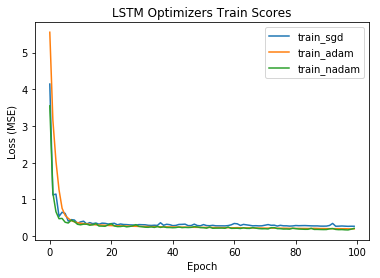

In [9]:
plt.plot(mse_train_sgd)
plt.plot(mse_train_adam)
plt.plot(mse_train_nadam)

plt.title('GRU Optimizers Train Scores')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')

plt.legend(['train_sgd','train_adam','train_nadam'])

print("Best Train Scores\n")

print("SGD Score:", np.min(mse_train_sgd))
print("Epoch:",np.argmin(mse_train_sgd))

print("\nAdam Score:", np.min(mse_train_adam))
print("Epoch:",np.argmin(mse_train_adam))


print("\nNadam Score:", np.min(mse_train_nadam))
print("Epoch:",np.argmin(mse_train_nadam))

# Test MSE

Best Test Scores 

SGD Score: 0.3490061436603272
Epoch: 89

Adam Score: 0.31834179357765546
Epoch: 85

Nadam Score: 0.3206035520126617
Epoch: 68


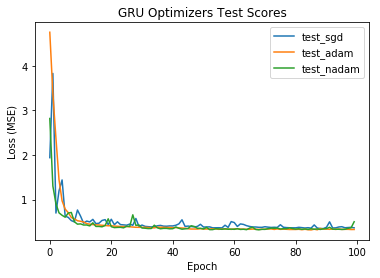

In [13]:
plt.plot(mse_test_sgd)
plt.plot(mse_test_adam)
plt.plot(mse_test_nadam)
plt.title('GRU Optimizers Test Scores')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')

plt.legend(['test_sgd','test_adam', 'test_nadam'])

print("Best Test Scores \n")
print("SGD Score:", np.min(mse_test_sgd))
print("Epoch:", np.argmin(mse_test_sgd))

print("\nAdam Score:", np.min(mse_test_adam))
print("Epoch:", np.argmin(mse_test_adam))

print("\nNadam Score:", np.min(mse_test_nadam))
print("Epoch:", np.argmin(mse_test_nadam))

# Train RMSE

Best Train Scores

SGD Score: 0.5186466453117583
Epoch: 97

Adam Score: 0.445802619607452
Epoch: 99

Nadam Score: 0.41367315235008456
Epoch: 97


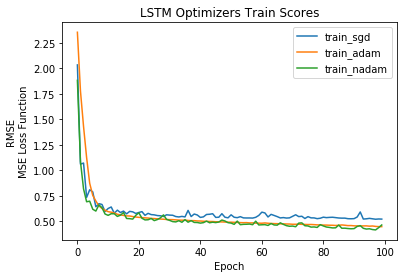

In [14]:
rmse_train_sgd = np.sqrt(mse_train_sgd)
rmse_train_adam = np.sqrt(mse_train_adam)
rmse_train_nadam = np.sqrt(mse_train_nadam)

plt.plot(rmse_train_sgd)
plt.plot(rmse_train_adam)
plt.plot(rmse_train_nadam)

plt.title('LSTM Optimizers Train Scores')
plt.xlabel('Epoch')
plt.ylabel('RMSE \nMSE Loss Function')

plt.legend(['train_sgd','train_adam','train_nadam'])

print("Best Train Scores\n")

print("SGD Score:", np.min(rmse_train_sgd))
print("Epoch:",np.argmin(rmse_train_sgd))

print("\nAdam Score:", np.min(rmse_train_adam ))
print("Epoch:",np.argmin(rmse_train_adam ))


print("\nNadam Score:", np.min(rmse_train_nadam))
print("Epoch:",np.argmin(rmse_train_nadam))

# Test RMSE

Best Train Scores

SGD Score: 0.5907674192610212
Epoch: 89

Adam Score: 0.5642178600307292
Epoch: 85

Nadam Score: 0.5662186432930849
Epoch: 68


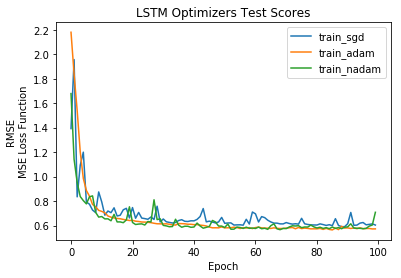

In [15]:
rmse_test_sgd = np.sqrt(mse_test_sgd)
rmse_test_adam = np.sqrt(mse_test_adam)
rmse_test_nadam = np.sqrt(mse_test_nadam)

plt.plot(rmse_test_sgd)
plt.plot(rmse_test_adam)
plt.plot(rmse_test_nadam)

plt.title('LSTM Optimizers Test Scores')
plt.xlabel('Epoch')
plt.ylabel('RMSE \nMSE Loss Function')

plt.legend(['train_sgd','train_adam','train_nadam'])

print("Best Train Scores\n")

print("SGD Score:", np.min(rmse_test_sgd))
print("Epoch:",np.argmin(rmse_test_sgd))

print("\nAdam Score:", np.min(rmse_test_adam ))
print("Epoch:",np.argmin(rmse_test_adam ))


print("\nNadam Score:", np.min(rmse_test_nadam))
print("Epoch:",np.argmin(rmse_test_nadam))

In [11]:
# GRU_df = pd.concat([
# pd.DataFrame(mse_test_sgd, columns=['SGD Test MSE']),
# pd.DataFrame(mse_test_adam, columns=['Adam Test MSE']),
# pd.DataFrame(mse_test_nadam, columns=['Nadam Test MSE']),
# pd.DataFrame(mse_train_sgd, columns=['SGD Train MSE']),
# pd.DataFrame(mse_train_adam, columns=['Adam Train MSE']),
# pd.DataFrame(mse_train_nadam, columns=['Nadam Train MSE'])
# ], axis = 1)

In [12]:
# GRU_df.to_csv('GRU_df_parametrization.csv')